Load and clean data

In [1]:
import SnowDepth as SD

# Assign seed
seed = 18

# Path to TIFF files
data_dir = "data/tif_files"

# Load dataframe
df = SD.data_loader.build_df(data_dir)

# Filter 0 ≤ SD (No upper threshold in this version)
clean_df = SD.data_loader.clean_df(df)

Split DataFrame into:

development -> (all but ID_BS)  
hold-out -> (ID_BS) 

In [2]:
dev_df  = clean_df[clean_df['aoi_name'] != 'ID_BS'].copy()
hold_df = clean_df[clean_df['aoi_name'] == 'ID_BS'].copy()

Split data for RF Duggal version

In [ ]:
X_train, y_train, X_val, y_val, X_hold, y_hold = SD.data_splitter.duggal_RF_split(
    dev_df=dev_df,
    hold_df=hold_df,
    seed=seed,
    features=[0, 1]
)

Features used for modeling: ['VH_dB', 'VV_dB']
X_train shape: (8400, 2)
X_val shape: (3600, 2)
X_hold shape: (1664925, 2)


Train RF and tune hyperparameters

In [ ]:
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Hyperparameter grid
param_grid = {
    "n_estimators": [300], # number of trees [100, 300, 500],
    "max_features": [1], # number of features to consider at each split [1, 2],
    "min_samples_leaf": [30] # minimum samples in a leaf node [1, 5, 10, 20, 30]
}

best_params = None
best_rmse   = float("inf")
best_mae    = float("inf")

for n_estimators, max_features, min_samples_leaf in itertools.product(
        param_grid["n_estimators"],
        param_grid["max_features"],
        param_grid["min_samples_leaf"]
    ):
    rf = RandomForestRegressor(
        n_estimators     = n_estimators,
        max_features     = max_features,
        min_samples_leaf = min_samples_leaf,
        random_state     = seed
    )
    rf.fit(X_train, y_train)
    val_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, val_pred)
    mae  = mean_absolute_error(y_val, val_pred)

    # Update if better RMSE, with MAE as tiebreaker
    if (rmse < best_rmse) or (rmse == best_rmse and mae < best_mae):
        best_rmse   = rmse
        best_mae    = mae
        best_params = {
            "n_estimators":     n_estimators,
            "max_features":     max_features,
            "min_samples_leaf": min_samples_leaf
        }

print(f"Best validation RMSE = {best_rmse:.3f}")
print(f"Corresponding MAE  = {best_mae:.3f}")
print("→ Best parameters:", best_params)

Best validation RMSE = 0.620
Corresponding MAE  = 0.486
→ Best parameters: {'n_estimators': 300, 'max_features': 1, 'min_samples_leaf': 30}


Retrain model on train + val

In [ ]:
import numpy as np
X_comb = np.vstack([X_train, X_val])
y_comb = np.concatenate([y_train, y_val])
best_rf = RandomForestRegressor(**best_params, random_state=seed)
best_rf.fit(X_comb, y_comb)

RandomForestRegressor(max_features=1, min_samples_leaf=30, n_estimators=300,
                      random_state=18)

Test best model on holdout AOI

In [ ]:
# Predict and calculate performance metrics
y_hold_pred = best_rf.predict(X_hold)
rmse_hold = root_mean_squared_error(y_hold, y_hold_pred)
mae_hold  = mean_absolute_error(y_hold, y_hold_pred)

print(f"Hold-out RMSE = {rmse_hold:.7f}")
print(f"Hold-out MAE  = {mae_hold:.7f}")

# Add predictions to Dataframe for visualization later
hold_df["SD_pred"] = y_hold_pred

Hold-out RMSE = 0.4627726
Hold-out MAE  = 0.3494380


Visualize results

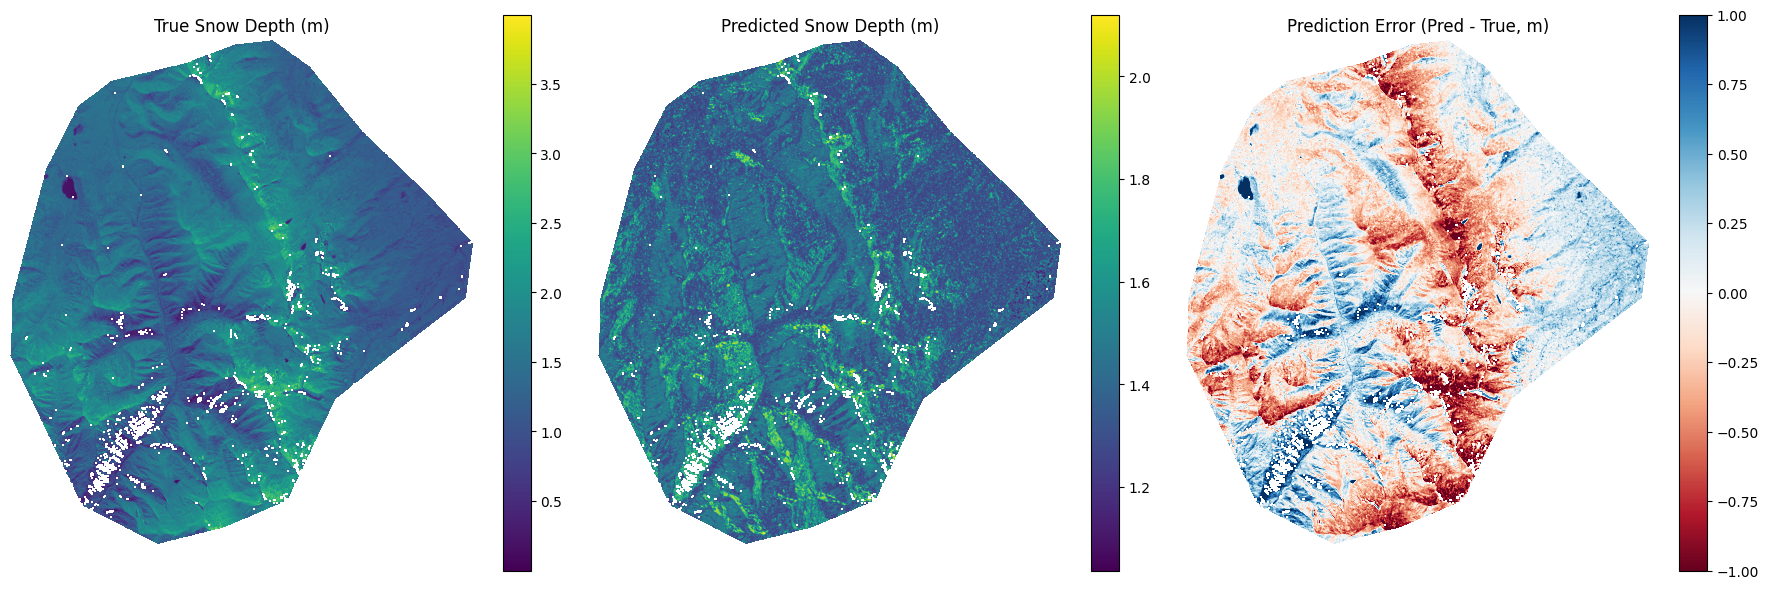

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get shape of the raster
n_rows = hold_df['row'].max() + 1
n_cols = hold_df['col'].max() + 1

# Step 2: Create empty arrays and fill them with NaNs
true_map  = np.full((n_rows, n_cols), np.nan)
pred_map  = np.full((n_rows, n_cols), np.nan)
error_map = np.full((n_rows, n_cols), np.nan)

# Step 3: Fill valid values using row/col
rows = hold_df['row'].values
cols = hold_df['col'].values
true_map[rows, cols]  = hold_df['SD'].values.flatten()
pred_map[rows, cols]  = hold_df['SD_pred'].values.flatten()
error_map[rows, cols] = (hold_df['SD_pred'].values - hold_df['SD'].values).flatten()

# Step 4: Plot all maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im0 = axs[0].imshow(true_map, cmap='viridis')
axs[0].set_title("True Snow Depth (m)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_map, cmap='viridis')
axs[1].set_title("Predicted Snow Depth (m)")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(error_map, cmap='RdBu', vmin=-1, vmax=1)
axs[2].set_title("Prediction Error (Pred - True, m)")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

